In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn, optim
from torch.nn.utils import clip_grad_norm
from nltk import word_tokenize
try: from torchtext.data import Field, LabelField, BucketIterator, TabularDataset
except: from torchtext.legacy.data import Field, LabelField, BucketIterator, TabularDataset
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import warnings
sns.set()
torch.manual_seed(0)
warnings.filterwarnings('ignore')

In [2]:
# Utils Functions
def evaluate_model(model, iterator, criterion):
    model.eval()
    loss = 0; correct = 0; total = 0; steps = len(iterator)
    with torch.no_grad():
        for input in iterator:
            data = input.cleaned_text.to(device)
            labels = input.label.to(device)
            preds = model(data)
            loss += criterion(preds, labels).item()
            pred_lbls = torch.softmax(preds, dim = 1).argmax(dim = 1)
            correct += (pred_lbls == labels).sum().item()
            total += len(labels)
        # End For 
    # End Block
    avg_loss = loss / steps
    accuracy = correct * 100 / total
    return avg_loss, accuracy
# End Func

def plt_progress(ax, train, valid, label = ''):
    ax.plot(train, label = f'Train {label}')
    ax.plot(valid, label = f'Valid {label}')
    ax.set_title(f'Train and Validation {label}', fontsize = 18)
    ax.set_xlabel('Epochs', fontsize = 16)
    ax.set_ylabel(label, fontsize = 16)
    ax.legend()
# End Func

def test_model(model, iterator, title = '', cls_names = None, figsize = [12, 10]):
    y_true = []; y_pred = []
    model.eval()
    with torch.no_grad():
        for data in iterator:
            X_test = data.cleaned_text.to(device)
            y_test = data.label
            y_pred.extend(model.predict(X_test).cpu().numpy())
            y_true.extend(y_test.numpy())
        # End For
    # End Block
    results = {}
    results['accuracy'] = accuracy_score(y_true, y_pred)
    results['precision'] = precision_score(y_true, y_pred, average = "macro")
    results['recall'] = recall_score(y_true, y_pred, average = "macro")
    results['f1'] = f1_score(y_true, y_pred, average = "macro")
    # print model results
    print('Model Evaluation' if len(title) == 0 else f'Model Evaluation ({title})')
    print('====================')
    print(f'Accuracy  : {(results["accuracy"] * 100):.2f}%')
    print(f'Precision : {(results["precision"] * 100):.2f}%')
    print(f'Recall    : {(results["recall"] * 100):.2f}%')
    print(f'F1_score  : {(results["f1"] * 100):.2f}%')
    print(f'Classification_Report : \n{classification_report(y_true, y_pred, target_names = cls_names)}')
    # plot confusion matrix 
    plt.figure(figsize = figsize)
    sns.heatmap(
        confusion_matrix(y_true, y_pred), 
        fmt='d', annot=True,
        xticklabels=cls_names, 
        yticklabels=cls_names
    )
    plt.title('Confusion Matrix' if len(title) == 0 else f'Confusion Matrix ({title})', fontsize = 16)
    plt.xlabel('Predicted Labels', fontsize = 14)
    plt.ylabel('True Labels', fontsize = 14)
    plt.show()
    return results
# End Func

In [3]:
data_file = "dataset_cleaned_version_{}.csv"
data_path = "../input/aim-task-dialects/aim_nlp_task_datasets"
the_best_model_path = './the_best_model.pt'
cls_names = ['AE', 'BH', 'DZ', 'EG', 'IQ', 'JO', 'KW', 'LB', 'LY', 'MA', 'OM', 'PL', 'QA', 'SA', 'SD', 'SY', 'TN', 'YE']
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# Convert Text to Seq
text_field = Field(
    tokenize=word_tokenize, 
    sequential=True, 
    use_vocab=True, 
    batch_first=True, 
    init_token="<sos>", 
    eos_token="<eos>"
)

label_field = LabelField(use_vocab=False, dtype = torch.long)

train_dataset, valid_dataset, test_dataset = TabularDataset.splits(
    path = data_path, format='csv', 
    train = data_file.format('train'), 
    validation = data_file.format('valid'), 
    test = data_file.format('test'),
    skip_header = True,
    fields = [
        ('cleaned_text', text_field), 
        ('label', label_field)
    ]
)

text_field.build_vocab(train_dataset)

In [5]:
# HYPERPARAMTERS
INPUT_DIM = len(text_field.vocab)
EMBED_SIZE = 300
OUTPUT_DIM = len(cls_names)
HIDDEN_SIZE = 512
BIDIRECTIONAL = False
NUM_LAYERS = 2
DROPOUT_PROP = 0.5
LEARNING_RATE = 0.0001
NUM_EPOCHS = 50
BATCH_SIZE = 128

In [6]:
# Init Data Iterators
train_dataset_iter, valid_dataset_iter, test_dataset_iter = BucketIterator.splits(
    (train_dataset, valid_dataset, test_dataset),
    batch_sizes = (BATCH_SIZE, 256, 256),
    sort_key = lambda x: len(x.cleaned_text)
)

In [7]:
class RNNModel(nn.Module):
    def __init__(
        self, 
        input_dim,
        embed_size,
        output_dim,
        hidden_size,
        bidirectional,
        num_layers,
        dropout_prop
    ):
        super(RNNModel, self).__init__()
        self.D = 2 if bidirectional else 1
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = nn.Embedding(input_dim, embed_size)
        self.rnn = nn.GRU(
            embed_size, hidden_size, 
            num_layers=num_layers, 
            bidirectional=bidirectional, 
            batch_first = True
        )
        self.fc = nn.Linear(self.D * hidden_size, output_dim)
        self.dropout = nn.Dropout(dropout_prop)
    # End Func
    
    def forward(self, input):
        N = input.shape[0]
        embedding_out = self.dropout(self.embedding(input))
        h_0 = torch.zeros(self.D * self.num_layers, N, self.hidden_size).to(device)
        _, out = self.rnn(embedding_out, h_0)
        out = torch.cat((out[-2, :, :], out[-1, :, :]), dim = 1) if self.D == 2 else out[-1, :, :] 
        out = self.fc(out)
        return out
    # End Func
    
    def predict(self, input):
        with torch.no_grad():
            return torch.softmax(self.forward(input), dim = 1).argmax(dim = 1)
        # End Block
    # End Func
# End Class

In [8]:
# Model Intitialization
model = RNNModel(
    input_dim=INPUT_DIM,
    output_dim=OUTPUT_DIM,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    bidirectional=BIDIRECTIONAL,
    embed_size=EMBED_SIZE,
    dropout_prop=DROPOUT_PROP
)

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [9]:
# Model Train
NUM_STEPS = len(train_dataset_iter)
train_loss = []; valid_loss = []; train_acc = []; valid_acc = []
the_best = 0
for epoch in range(NUM_EPOCHS):
    correct = 0; total = 0
    for step, input in enumerate(train_dataset_iter):
        data = input.cleaned_text.to(device)
        labels = input.label.to(device)
        model.train()
        y_hat = model(data)
        with torch.no_grad():
            preds_lbls = torch.softmax(y_hat, dim = 1).argmax(dim = 1)
            step_correct = (preds_lbls == labels).sum().item()
            correct += step_correct
            total += len(labels)
        # End Block
        loss = criterion(y_hat, labels)
        optimizer.zero_grad()
        loss.backward()
        clip_grad_norm(model.parameters(), max_norm=1.0)
        optimizer.step()
        progress = (step + 1) * 100 // NUM_STEPS
        end = '\n' if progress == 100 else '\r'
        print(f"Epoch: [{epoch + 1}/{NUM_EPOCHS}] - Progress: {progress}% - Training Loss: {loss.item():.4} - Training Accuracy: {(step_correct * 100 / len(labels)):.2f}%", end = end)
    # End For
    train_loss.append(loss.item())
    train_acc.append(correct * 100 / total)
    valid_loss_val, valid_acc_val = evaluate_model(model, valid_dataset_iter, criterion)
    valid_loss.append(valid_loss_val)
    valid_acc.append(valid_acc_val)
    
    # Save the best model
    if valid_acc_val > the_best:
        the_best = valid_acc_val
        torch.save(model, the_best_model_path)
    # End If
# End For

Epoch: [1/50] - Progress: 100% - Training Loss: 2.484 - Training Accuracy: 18.75%
Epoch: [2/50] - Progress: 100% - Training Loss: 2.35 - Training Accuracy: 24.22%
Epoch: [3/50] - Progress: 100% - Training Loss: 2.308 - Training Accuracy: 27.34%
Epoch: [4/50] - Progress: 100% - Training Loss: 2.146 - Training Accuracy: 31.25%
Epoch: [5/50] - Progress: 100% - Training Loss: 2.134 - Training Accuracy: 33.59%
Epoch: [6/50] - Progress: 100% - Training Loss: 1.97 - Training Accuracy: 33.59%
Epoch: [7/50] - Progress: 100% - Training Loss: 2.031 - Training Accuracy: 34.38%
Epoch: [8/50] - Progress: 100% - Training Loss: 1.896 - Training Accuracy: 37.50%
Epoch: [9/50] - Progress: 100% - Training Loss: 1.726 - Training Accuracy: 43.75%
Epoch: [10/50] - Progress: 100% - Training Loss: 1.932 - Training Accuracy: 35.94%
Epoch: [11/50] - Progress: 100% - Training Loss: 1.803 - Training Accuracy: 46.88%
Epoch: [12/50] - Progress: 100% - Training Loss: 1.799 - Training Accuracy: 44.53%
Epoch: [13/50] 

Model Evaluation (GRU Model)
Accuracy  : 48.47%
Precision : 49.43%
Recall    : 43.23%
F1_score  : 44.44%
Classification_Report : 
              precision    recall  f1-score   support

          AE       0.45      0.29      0.35      2571
          BH       0.28      0.26      0.27      2542
          DZ       0.51      0.50      0.51      1624
          EG       0.56      0.86      0.68      5722
          IQ       0.63      0.43      0.51      1502
          JO       0.35      0.29      0.32      2843
          KW       0.42      0.56      0.48      4174
          LB       0.49      0.68      0.57      2746
          LY       0.66      0.61      0.63      3700
          MA       0.66      0.56      0.60      1160
          OM       0.33      0.37      0.35      1934
          PL       0.51      0.43      0.47      4434
          QA       0.46      0.40      0.43      3085
          SA       0.34      0.38      0.36      2680
          SD       0.70      0.53      0.60      1450
     

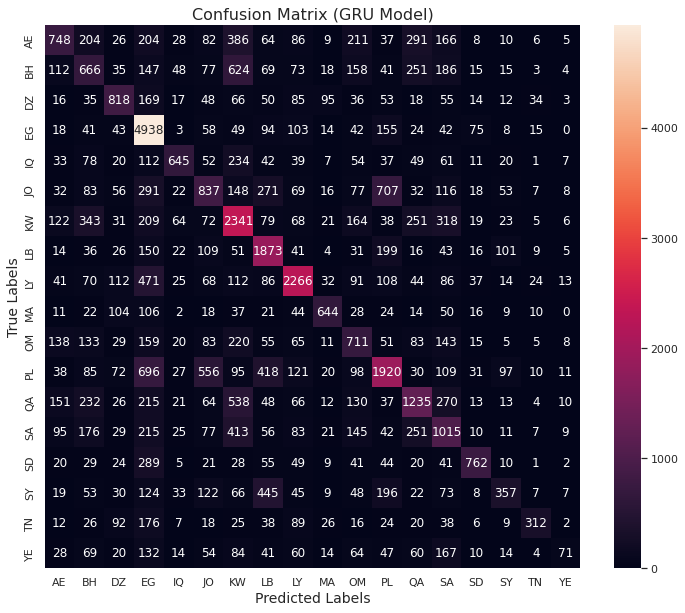

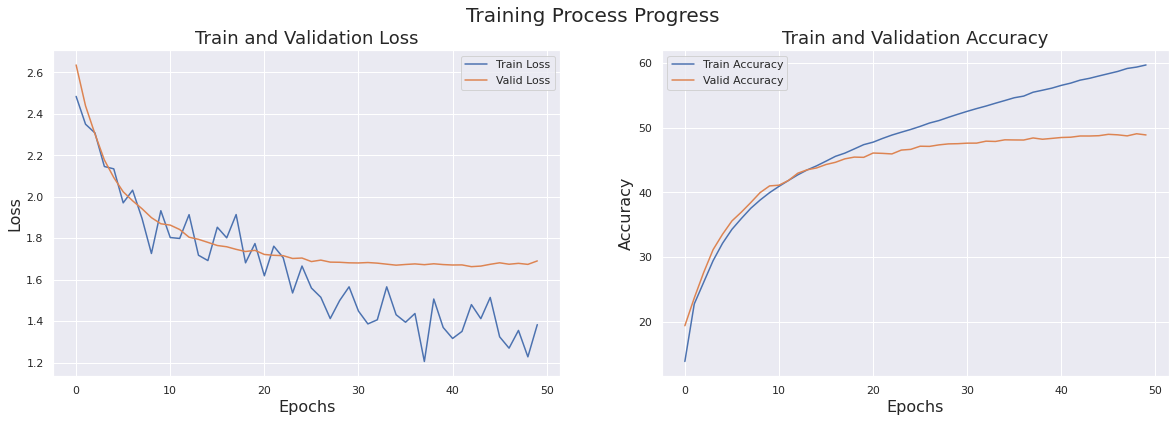

In [10]:
# Test The Model Progress
model_results = test_model(
    model = model, 
    iterator = test_dataset_iter, 
    title = 'GRU Model', 
    cls_names = cls_names
)

# Plot The Learning Curves 
fig, axes = plt.subplots(1, 2, figsize = [20, 6])
axes = axes.ravel()
fig.suptitle('Training Process Progress', fontsize = 20)
plt_progress(axes[0], train_loss, valid_loss, label='Loss')
plt_progress(axes[1], train_acc, valid_acc, label='Accuracy')
plt.show()